## Laboratory of Computational Physics mod. B at Phisics of Data, University of Padova

__Authors:__

- Valeria Fioroni (University of Padova)
- Matteo Guida (University of Padova)
- Philipp Zehetner (University of Padova, Ludwig Maximilian University of Munich)

__Supervised by:__

- Professor Marco Zanetti (University of Padova, CERN)
- Professor Stefano Lacaprara (University of Padova, BELLE2)

###  Description 
---
<center>The goal of this project is to find the branching ratio of: <br> <br>
$B^0 \rightarrow \eta' K_S^0$ <center>

with the following considered channel :  

$\eta' \rightarrow \eta \, (\rightarrow \gamma \gamma) \; \pi^+ \pi^-$, <br>
$\eta' \rightarrow \eta \, (\rightarrow \pi^+ \pi^- \pi^{-0})\pi^+ \pi^-$ <br>
$\eta' \rightarrow \rho \, (\rightarrow \pi^+ \pi^- )\gamma\,\,$  and <br>
$K_S^0 \rightarrow \pi^+ \pi^-$<br>
in Monte Carlo simulation (Data Challenge).

To do this, we build a deep neural network (DNN) with Keras/Tensorflow using labelled data, optimize it and finally use it as a classifier on the data challenge files.

In [3]:
import os, sys, pprint
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings

In [4]:
Testing = False # Uses only a small subset of the data and trains on fewer epochs. 
PCA_ON = False
cut_5_sigma = False
VM = True
Local_Philipp = False
Local_Valeria = False


if Testing: print("For testing purpose only a small number of events are used")
if Local_Philipp : print("Paths are set to be run on Philipps Computer")
elif VM : print("Paths are set to run on the VM")

Paths are set to run on the VM


## 1. Reading and Cleaning Data
The dataset is candidate based so each entry correspond to one candidate. 

In this chapter we:
- import the root files into pandas dataframes  selecting only the features of interest for our analysis
- clean our data sets by removing wrongly reconstructed signal and allowing only one true signal candidate per event.
- apply a $5\sigma$ cut on the mass of the reconstructed $B^0$ on all candidates

In [5]:
# Define branches that we need for our analysis
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal', 'evt_no']

In [6]:
def memory(df):
    return str((round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2)))+"  Mb"

In [7]:
from root_pandas import read_root
warnings.filterwarnings("ignore")

if Local_Philipp and not VM : 
    path = '/home/philipp/Desktop/Project/DATA/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Continuous/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Peaking/*.root'))
    
elif VM and not Local_Philipp : 
    path = '/home/Students/DataBelle2_all/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    
elif Local_Matteo:  
    path = '/home/guida/Scrivania/PROJECT_2/DataBelle2'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    
elif Local_Valeria:  
    path = '/home/utente/Scrivania/Progetto LCP-B/DataBelle2/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    

Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Signal = Signal[Signal['B0_isSignal']==1].reset_index(drop=True)
Continuum_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

print ("Memory used by Signal : ", memory(Signal))
print ("Memory used by Continuum : ", memory(Continuum_bkg))
print ("Memory used by Peaking  :  ", memory(Peaking_bkg),"\n")

print("Peaking shape : ",Peaking_bkg.shape)
print("Continuum shape : ",Continuum_bkg.shape)
print("Signal shape : ",Signal.shape)

Welcome to JupyROOT 6.16/00


/home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.4 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


Memory used by Signal :  71.3  Mb
Memory used by Continuum :  81.75  Mb
Memory used by Peaking  :   0.72  Mb 

Peaking shape :  (2167, 85)
Continuum shape :  (246329, 85)
Signal shape :  (219897, 85)


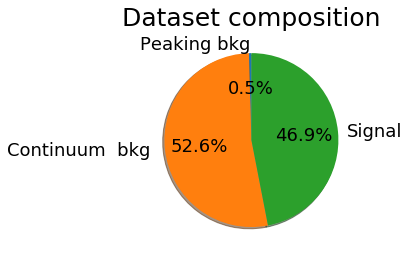

In [8]:
labels = 'Peaking bkg', 'Continuum  bkg ', 'Signal'
sizes = [Peaking_bkg.shape[0],Continuum_bkg.shape[0],Signal.shape[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 18})  
ax1.set_title('Dataset composition', fontsize=25)
plt.show()

### $5\sigma$ Cut on Reconstructed $B^0$ Mass

The reconstructed mass of the $B^0$ will differ for various reasons: 

- If an event is correctly reconstructed detector inaccuracies of all measured decay particles will add up. The estimated error for each candidate due to this can be found in the branch *B0_ErrM* and is part of our data frame. 
- If the event however is not correctly reconstructed the $B^0$ mass is not necessarily a meaningful quantity an can be far of the desired [PDG](http://pdg.lbl.gov/) value. 

By applying a generous $5\sigma$ cut we already lose a significant amount of background

In [9]:
#Masses from PDG
if cut_5_sigma == True: 
    M_B0 = [5.27955, 0.00026]
    M_K0 = [0.497611, 0.000013]
    M_etap = [0.95778, 0.00006]
    M_eta = [0.547862, 0.000017]

    #Require the B0 mass to be within 5 sigma from PDG value
    Signal = Signal[abs(Signal['B0_M'] - M_B0[0]) < 5 * Signal['B0_ErrM']]
    print("Signal : ",Signal.shape)

    Continuum_bkg = Continuum_bkg[abs(Continuum_bkg['B0_M'] - M_B0[0]) < 5 * Continuum_bkg['B0_ErrM']]
    print("Continuum : ", Continuum_bkg.shape)

    Peaking_bkg = Peaking_bkg[abs(Peaking_bkg['B0_M'] - M_B0[0]) < 5 * Peaking_bkg['B0_ErrM']]
    print("Peaking : ",Peaking_bkg.shape)

Comment

The decision not to use the PCA was determined considering that the results of the network are worse in that case, leaving all the other parameters unchanged. 

In [10]:
#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)

Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

print("Signal : ",Signal.shape)
print("Uniqueness check evt_no : ", Signal['evt_no'].nunique())
print("Continuum : ",Continuum_bkg.shape)
print("Signal : ",Signal.shape)
print("% of peaking on the entire dataset : ",round((Peaking_bkg.shape[0])/(Peaking_bkg.shape[0]+Continuum_bkg.shape[0]+Signal.shape[0])*100,3))

Signal=Signal[Training]
Continuum_bkg=Continuum_bkg[Training]
Peaking_bkg=Peaking_bkg[Training]

Signal :  (218596, 85)
Uniqueness check evt_no :  218596
Continuum :  (246329, 85)
Signal :  (218596, 85)
% of peaking on the entire dataset :  0.464


## 2. Data Preprocessing

In this chapter we:
- label our data.
- turn the label into one-hot vectors as this format is needed by Keras.
- split signal, continuum and peaking separatly into training (50%), valdation (30%) and testing (20%) and then remerge  them together to assure that the balance in the composition of the dataset is preserved.
- combine and shuffle signal, continuum and peaking for training, validation and testing, making sure that the labels are shuffled with the same permutation as the data
- standardize the data (removing mean and scaling the standard deviation to 1)
- perform a Principal Component Analysis (PCA) and use the components necessary for 99% of the variance.

In [11]:
from random import seed
from random import randint

n_seed=1234
seed(n_seed)

In [12]:
Signal['Type'] = 2
Continuum_bkg['Type'] = 1
Peaking_bkg['Type'] = 0

In [13]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#SIGNAL: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Signal.drop('Type',axis=1)
Y = Signal['Type']
#Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)

#CONTINUUM BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Continuum_bkg.drop('Type',axis=1)
Y = Continuum_bkg['Type']
#Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)

#PEAKING BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Peaking_bkg.drop('Type',axis=1)
Y = Peaking_bkg['Type']
##Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

del(Signal)
del(Peaking_bkg)
del(Continuum_bkg)


Using TensorFlow backend.


In [16]:
#Define Training, Validation and Test datasets
X_Train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_Validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_Test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)


Y_Train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_Validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_Test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)
Ỳ_Test_not_encoded=Y_Test #needed for cut value analysis

Y_Train=to_categorical(Y_Train, num_classes=3) # Binarize the labels
Y_Validation=to_categorical(Y_Validation, num_classes=3) # Binarize the labels
Y_Test=to_categorical(Y_Test, num_classes=3) # Binarize the labels

n_classes = Y_Train.shape[1]

print("X Train shape : ", X_Train.shape)
print("X Validation shape : ",X_Validation.shape)
print("X Test shape : ",X_Test.shape)

X Train shape :  (233545, 83)
X Validation shape :  (140127, 83)
X Test shape :  (93420, 83)


In [17]:
#shuffle the dataset
permutation = np.random.permutation(X_Train.shape[0])
X_Train = X_Train[permutation]
Y_Train = Y_Train[permutation]

permutation = np.random.permutation(X_Validation.shape[0])
X_Validation = X_Validation[permutation]
Y_Validation = Y_Validation[permutation]

permutation = np.random.permutation(X_Test.shape[0])
X_Test = X_Test[permutation]
Y_Test = Y_Test[permutation]

In [18]:
from sklearn.preprocessing import StandardScaler

# standardize the data
ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)
X_Validation = ss.transform(X_Validation)

## PCA

Principal component analysis is a method often used to reduce the dimensionality of a data set. Orthogonal transformations are performed on the data set to find the directions with the highest variance. The rotated features (principal components) are sorted in descending variance. The assumption made is, that high variance corresponds to more information and little variance can be neglected as noise.

In our example we require to keep 99% of the total variance and thus can reduce the number of components from 83 to 50

12 variables explain 50% of the variance
36 variables explain 90% of the variance
42 variables explain 95% of the variance
50 variables explain 99% of the variance 

% of dataset reduction with 99 % explained variance : 39.8


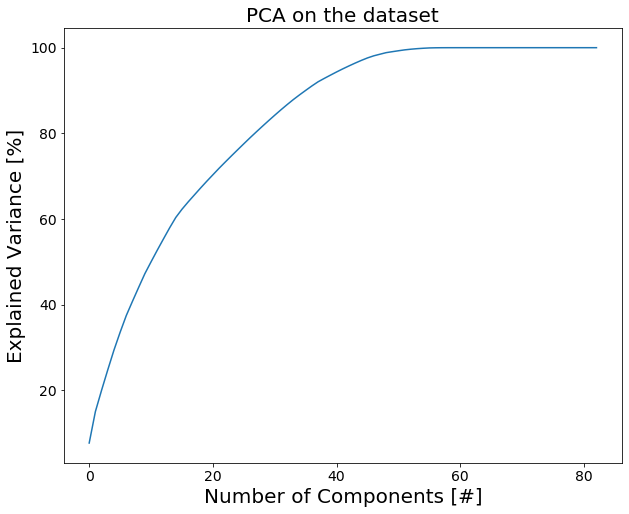

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline


pca = PCA(n_components=len(Training))
data = pca.fit_transform(X_Train)
pcTrain = pd.DataFrame(data)
pcTest = pd.DataFrame(data = pca.transform(X_Test))
pcValidation = pd.DataFrame(data = pca.transform(X_Validation))

T50, T90, T95, T99, = False, False, False, False
for i in range(len(pca.explained_variance_ratio_)) : 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.5 and T50 ==False) : 
        print(str(i+1) + ' variables explain 50% of the variance')
        T50 = True
        n_50 = i + 1 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.9 and T90 ==False) : 
        print(str(i+1) + ' variables explain 90% of the variance')
        T90 = True
        n_90 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.95 and T95 ==False) : 
        print(str(i+1) + ' variables explain 95% of the variance')
        T95 = True
        n_95 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.99 and T99 ==False) : 
        print(str(i+1) + ' variables explain 99% of the variance \n')
        T99 = True
        n_99 = i + 1
        
fig = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.title('PCA on the dataset',fontsize=20)
plt.xlabel('Number of Components [#]',fontsize=20)
plt.ylabel('Explained Variance [%]',fontsize=20)
plt.tick_params(labelsize=14)
fig.set_size_inches(10, 8)
print('% of dataset reduction with 99 % explained variance :',round((X_Train.shape[1]-n_99)/X_Train.shape[1]*100,1))

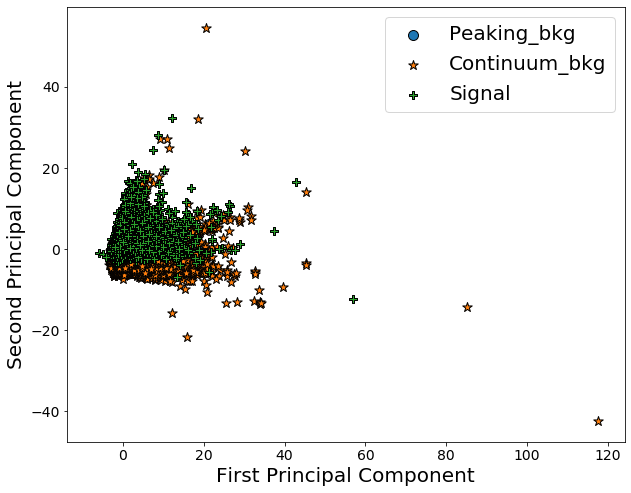

In [20]:
fig = plt.figure()
Y_Train_single_col=np.where(Y_Train==1)[1]
plt.scatter(data[Y_Train_single_col==0,0],data[Y_Train_single_col==0,1], label='Peaking_bkg',edgecolors='black',marker="o",s=100)
plt.scatter(data[Y_Train_single_col==1,0],data[Y_Train_single_col==1,1], label="Continuum_bkg", edgecolors='black', marker="*",s=100)
plt.scatter(data[Y_Train_single_col==2,0],data[Y_Train_single_col==2,1], label='Signal', edgecolors='black', marker="P",s=80)
plt.xlabel('First Principal Component',fontsize=20)
plt.ylabel('Second Principal Component',fontsize=20)
fig.set_size_inches(10, 8)
plt.tick_params(labelsize=14)
plt.legend(fontsize=20)
plt.show()

if not PCA_ON :  
    pcTrain = X_Train
    pcTest = X_Test
    pcValidation = X_Validation

In [21]:
if PCA_ON : 
    pca = PCA(n_components=n_99)
    pcTrain = pca.fit_transform(X_Train)
    pcTest = pd.DataFrame(data = pca.transform(X_Test))
    pcValidation = pd.DataFrame(data = pca.transform(X_Validation))
    print ("Input Dimension has been reduced to ", n_99)
else : 
    input_dim = 83
    print("Input Dimension has not been reduced and no PCA has been performed")

Input Dimension has not been reduced and no PCA has been performed


####  Comment
The decision not to use the PCA was determined considering that the results of the network are worse in that case, leaving all the other parameters unchanged. 
The result that gets worse is the true positive rate in the case of peaking background.

Peaking backgound accounts for 0.46 % of the total dataset. <br>
We believe that PCA embeds the dataset in the space generated by the eigenvectors that maximizes the variance explained for the rest of the dataset, but that penalizes important variables in the distinction of peaking background. <br>
In fact $\sigma \propto \sqrt{N} $ and $N_{pkg} \ll N_{tot} $, $N_{pkg}$ should be very isolated in the phase space so that its characterizing variables are kept in strong consideration. This is not the case with the analyzed dataset.

## 3. Create the Neural Network 

In [22]:
architectures = [ [30, 70, 30], [50, 150, 50], [50, 100, 100, 50] ] 
activation = ['elu', 'leakyrelu', 'relu']
optimizer = ['SGD', 'Adam',' AdaMax']
epochs = [15]
if Testing : epochs = [1, 2]
batch_size = [100, 1000]

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier

def build_DNN(optimizer='adam', activation='elu'):
    model = Sequential()
    model.add(Dropout(0.3, input_shape=(pcTrain.shape[1],)))
    model.add(Dense(layers[0], input_shape=(pcTrain.shape[1],), activation='elu'))
    for i in range(1,len(layers)):
        model.add(Dense(layers[i], activation='elu', kernel_constraint=maxnorm(3)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def print_results() :
    print("Layers: ", layers)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params): 
        print("%f (%f) with %r" % (mean, stdev, param))


In [24]:
%%time
import os
from sklearn.model_selection import GridSearchCV
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore")

results = []
grids = []
for architecture in architectures : 
    layers = architecture
    print("Using architecture: ", layers)
    model = KerasClassifier(build_fn=build_DNN, batch_size=1000, epochs=2,verbose=0)
    param_grid = dict(epochs=epochs, batch_size=batch_size,
                      activation=activation, optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        n_jobs=-1, pre_dispatch=8,cv=4,verbose=0)
    grid_result = grid.fit(pcTrain, Y_Train)
    results.append(grid_result)
    grids.append(grid)
    print_results()

Using architecture:  [30, 70, 30]


W0724 08:11:26.321161 140715109656384 deprecation_wrapper.py:119] From /home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 08:11:26.339491 140715109656384 deprecation_wrapper.py:119] From /home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 08:11:26.343143 140715109656384 deprecation_wrapper.py:119] From /home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0724 08:11:26.354246 140715109656384 deprecation.py:506] From /home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/keras/backend/tensorf

Layers:  [30, 70, 30]
Best: 0.983091 using {'activation': 'leakyrelu', 'batch_size': 100, 'epochs': 15, 'optimizer': ' AdaMax'}
0.981216 (0.000543) with {'activation': 'elu', 'batch_size': 100, 'epochs': 15, 'optimizer': 'SGD'}
0.982188 (0.000369) with {'activation': 'elu', 'batch_size': 100, 'epochs': 15, 'optimizer': 'Adam'}
0.982051 (0.000839) with {'activation': 'elu', 'batch_size': 100, 'epochs': 15, 'optimizer': ' AdaMax'}
0.981854 (0.000648) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 15, 'optimizer': 'SGD'}
0.982427 (0.000645) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 15, 'optimizer': 'Adam'}
0.982123 (0.000788) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 15, 'optimizer': ' AdaMax'}
0.982667 (0.000343) with {'activation': 'leakyrelu', 'batch_size': 100, 'epochs': 15, 'optimizer': 'SGD'}
0.981528 (0.000690) with {'activation': 'leakyrelu', 'batch_size': 100, 'epochs': 15, 'optimizer': 'Adam'}
0.983091 (0.000752) with {'activation': 'leaky

Using TensorFlow backend.
W0724 07:50:29.934718 139771027076928 deprecation_wrapper.py:119] From /home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 07:50:29.954418 139771027076928 deprecation_wrapper.py:119] From /home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 07:50:29.956298 139771027076928 deprecation_wrapper.py:119] From /home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0724 07:50:29.966318 139771027076928 deprecation.py:506] From /home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-pack

In [26]:
scores = []
params = []
for result in results : 
    scores.append(result.best_score_)
    params.append(result.best_params_)
    pprint.pprint(result.best_score_)
    pprint.pprint(result.best_params_)

0.9830910636920374
{'activation': 'leakyrelu',
 'batch_size': 100,
 'epochs': 15,
 'optimizer': ' AdaMax'}
0.9823417438324835
{'activation': 'leakyrelu', 'batch_size': 100, 'epochs': 15, 'optimizer': 'SGD'}
0.9829668794391564
{'activation': 'relu', 'batch_size': 1000, 'epochs': 15, 'optimizer': 'Adam'}


### Evaluate the best Network

In [27]:
Best_Score = max(scores) # Best Score: 
Best_Params = params[scores.index(Best_Score)]
Best_Arch = architectures[scores.index(Best_Score)]
layers = Best_Arch
Best_Model = build_DNN(optimizer = Best_Params['optimizer'],
                       activation = Best_Params['activation'])
Best_Model.fit(pcTrain, Y_Train, batch_size = Best_Params['batch_size'],
               epochs = Best_Params['epochs'])

Epoch 1/15
233545/233545 [==============================] - 27s 116us/step - loss: 0.1268 - acc: 0.9590
Epoch 2/15
233545/233545 [==============================] - 15s 65us/step - loss: 0.0958 - acc: 0.9700
Epoch 3/15
233545/233545 [==============================] - 15s 65us/step - loss: 0.0911 - acc: 0.9714
Epoch 4/15
233545/233545 [==============================] - 15s 65us/step - loss: 0.0882 - acc: 0.9727
Epoch 5/15
233545/233545 [==============================] - 15s 63us/step - loss: 0.0857 - acc: 0.9734
Epoch 6/15
233545/233545 [==============================] - 15s 66us/step - loss: 0.0847 - acc: 0.9738
Epoch 7/15
233545/233545 [==============================] - 15s 66us/step - loss: 0.0827 - acc: 0.9745
Epoch 8/15
233545/233545 [==============================] - 15s 66us/step - loss: 0.0823 - acc: 0.9744
Epoch 9/15
233545/233545 [==============================] - 15s 65us/step - loss: 0.0809 - acc: 0.9750
Epoch 10/15
233545/233545 [==============================] - 16s 66us/st

In [28]:
print("Evaluation Train", Best_Model.evaluate(pcTrain, Y_Train))
print("Evaluation Validation", Best_Model.evaluate(pcValidation, Y_Validation))
print("Evaluation Test", Best_Model.evaluate(pcTest, Y_Test))

233545/233545 [==============================] - 35s 151us/step
Evaluation Train [0.057409992742124744, 0.983634845533236]
140127/140127 [==============================] - 18s 129us/step
Evaluation Validation [0.06027559853957129, 0.9830796349030494]
93420/93420 [==============================] - 12s 128us/step
Evaluation Test [0.05916113777784381, 0.9831085420680796]


In [29]:
train_prediction = Best_Model.predict(pcTrain)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

N_true = 0
N_false = 0
for i in range(len(train_pred)) : 
    if np.array_equal(train_pred[i],Y_Train[i]) : N_true += 1
    else : N_false += 1
        

print("Training:")
print ("Accuracy = ", N_true/(N_true+N_false))
print ("N_true: ", N_true)
print ("N_false: ", N_false)

Training:
Accuracy =  0.9836348455329808
N_true:  229723
N_false:  3822


In [30]:
train_prediction = Best_Model.predict(pcValidation)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

N_true = 0
N_false = 0
for i in range(len(train_pred)) : 
    if np.array_equal(Y_Validation[i], train_pred[i]) : N_true += 1
    else : N_false += 1
        

print ("Validation:")        
print ("Accuracy = ", N_true/(N_true+N_false))
print ("N_true: ", N_true)
print ("N_false: ", N_false)

Validation:
Accuracy =  0.9830796349026241
N_true:  137756
N_false:  2371


In [31]:
print("Trainig Error : ",1-Best_Model.evaluate(pcTrain, Y_Train)[1])
print("Validation Error : ",1-Best_Model.evaluate(pcValidation, Y_Validation)[1])

233545/233545 [==============================] - 30s 127us/step
Trainig Error :  0.01636515446676401
140127/140127 [==============================] - 18s 128us/step
Validation Error :  0.016920365096950607


In [32]:
y_score = Best_Model.predict(pcValidation)

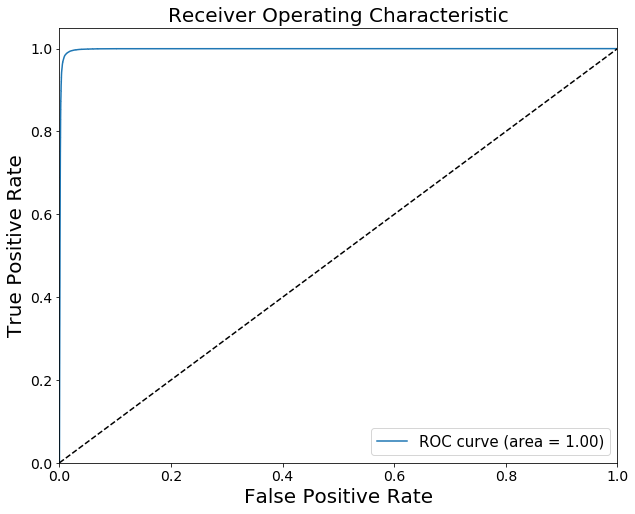

In [33]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_Validation[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
fig = plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver Operating Characteristic',fontsize=20)
plt.tick_params(labelsize=14)
plt.legend(loc="lower right",fontsize=15)
fig.set_size_inches(10, 8)
plt.show()

### Confusion Matrix on Train and Validation Set

In [61]:
def plot_confusion_matrix(cm, classes,
                          title1='Confusion matrix \n with normalization',
                          title2='Confusion matrix \n without normalization',
                          cmap=plt.cm.YlOrRd):

    cm0 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized 
    cm1 = cm # unnormalized
    fmt0 = '.2f' 
    fmt1 = 'd'
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)
    im1=ax1.imshow(cm0, interpolation='nearest', cmap=cmap)
    ax1.set_title(title1,fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax1.set_xticks(tick_marks)
    ax1.set_xticklabels(dict(zip(classes,tick_marks)), rotation=30,fontsize=15)
    ax1.set_yticks(tick_marks)
    ax1.set_yticklabels(dict(zip(classes,tick_marks)),fontsize=15)
    fig.colorbar(im1, ax=ax1)
    
    thresh = cm0.max() / 2.
    for i, j in itertools.product(range(cm0.shape[0]), range(cm0.shape[1])):
        ax1.text(j, i, format(cm0[i, j], fmt0),
                 horizontalalignment="center",
                 color="black" if cm0[i, j] > thresh else "black",fontsize=15)

    ax1.set_ylabel('TRUE LABEL',fontsize=20)
    ax1.set_xlabel('PREDICTED LABEL',fontsize=20)

    im2=ax2.imshow(cm1, interpolation='nearest', cmap=cmap)
    ax2.set_title(title2,fontsize=25)

    ax2.set_xticks(tick_marks)
    ax2.set_xticklabels(dict(zip(classes,tick_marks)), rotation=30,fontsize=15)
    ax2.set_yticks(tick_marks)
    ax2.set_yticklabels(dict(zip(classes,tick_marks)),fontsize=15)
    
    thresh = cm1.max() / 2.
    for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
        ax2.text(j, i, format(cm1[i, j], fmt1),
                 horizontalalignment="center",
                 color="black" if cm1[i, j] > thresh else "black",fontsize=15)

    ax2.set_ylabel('TRUE LABEL',fontsize=20)
    ax2.set_xlabel('PREDICTED LABEL',fontsize=20)
    fig.colorbar(im2, ax=ax2)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

# On training set
Y_train_predict = Best_Model.predict_proba(X_Train)
Y_train_single_col = np.where(Y_Train==1)[1]
Y_train_mo = pd.get_dummies(Y_train_single_col[:])
Y_train_predict_mo = Y_train_predict.round()

In [55]:
cnf_matrix_train = confusion_matrix(Y_train_mo.values.argmax(axis=1), Y_train_predict_mo.argmax(axis=1))

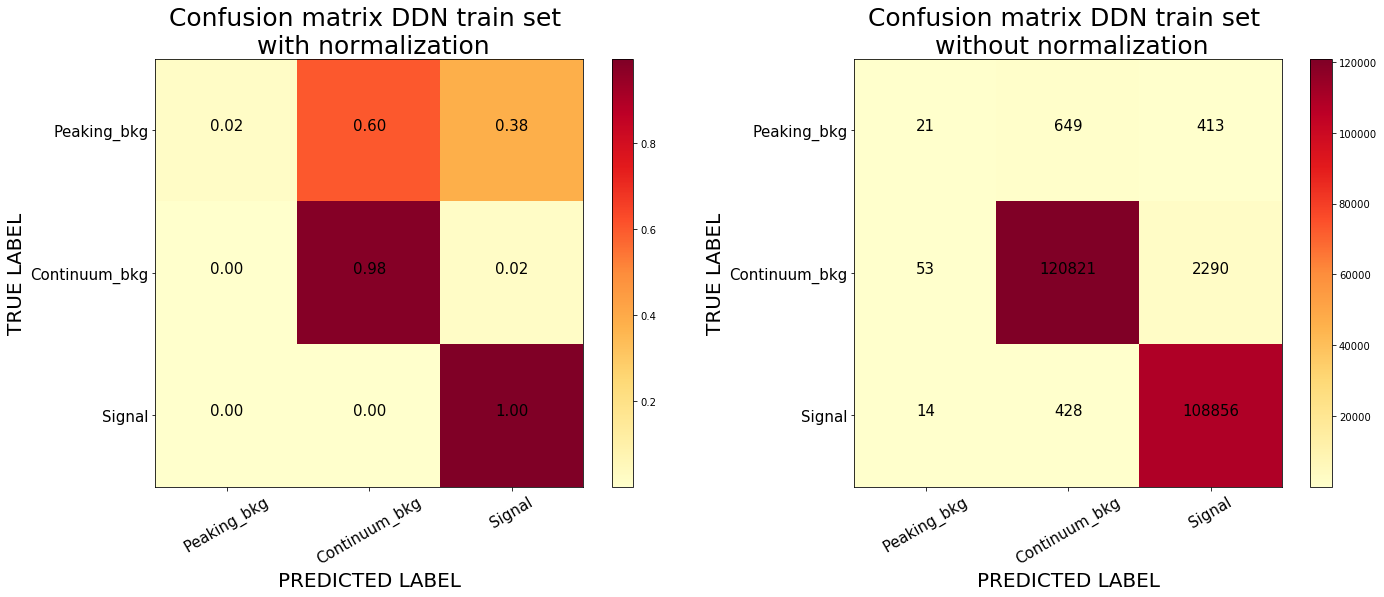

In [63]:
plot_confusion_matrix(cnf_matrix_train, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title1='Confusion matrix DDN train set \n with normalization',title2='Confusion matrix DDN train set \n without normalization')

In [57]:
# On validation set
Y_val_predict = Best_Model.predict_proba(X_Validation)
Y_val_single_col = np.where(Y_Validation==1)[1]
Y_val_mo = pd.get_dummies(Y_val_single_col[:])
Y_val_predict_mo = Y_val_predict.round()
cnf_matrix_val = confusion_matrix(Y_val_mo.values.argmax(axis=1), Y_val_predict_mo.argmax(axis=1))

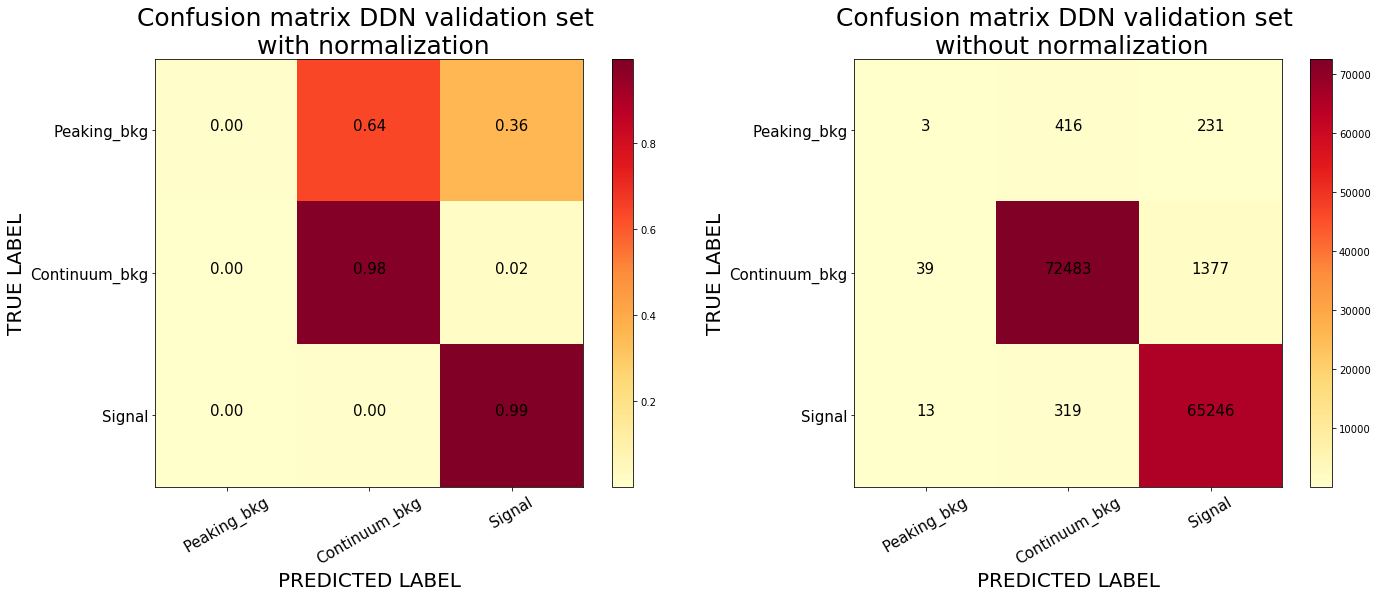

In [64]:
plot_confusion_matrix(cnf_matrix_val, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title1='Confusion matrix DDN validation set \n with normalization',title2='Confusion matrix DDN validation set \n without normalization')

### Saving Model, weights, standard scaler and PCA if used

In [39]:
import joblib

joblib.dump(ss, 'Scaler.pkl')
if PCA_ON :     
    joblib.dump(pca, 'PCA.pkl')
    
Best_Model.save("Best_Model.h5")

In [40]:
Best_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_148 (Dropout)        (None, 83)                0         
_________________________________________________________________
dense_662 (Dense)            (None, 30)                2520      
_________________________________________________________________
dense_663 (Dense)            (None, 70)                2170      
_________________________________________________________________
dense_664 (Dense)            (None, 30)                2130      
_________________________________________________________________
dense_665 (Dense)            (None, 3)                 93        
Total params: 6,913
Trainable params: 6,913
Non-trainable params: 0
_________________________________________________________________


### Try Loading the model

In [41]:
from keras.models import load_model
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings("ignore")
Loaded_Model = load_model('Best_Model.h5')
Loaded_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_148 (Dropout)        (None, 83)                0         
_________________________________________________________________
dense_662 (Dense)            (None, 30)                2520      
_________________________________________________________________
dense_663 (Dense)            (None, 70)                2170      
_________________________________________________________________
dense_664 (Dense)            (None, 30)                2130      
_________________________________________________________________
dense_665 (Dense)            (None, 3)                 93        
Total params: 6,913
Trainable params: 6,913
Non-trainable params: 0
_________________________________________________________________


In [45]:
Loaded_Model.evaluate(pcTest, Y_Test, verbose=1)

93420/93420 [==============================] - 18s 195us/step


[0.06013732372881421, 0.9830443159922929]

## 4 XGBOOST

To achieve the task of the classification we have tried to look at the results of the Xgboost algorithm. <br>
In fact, besides being one of the best performing algorithms to perform this type of task, [here](https://github.com/dmlc/xgboost/tree/master/demo) you can see, not only great tutorials, but also that the algorithm won several high energy physics ML competitions. <br><br>
The basic idea of the algorithm is to construct ensembles of decision trees. It work iteratively and at each step, we compute the gradient of the cost function w.r.t.the predicted value of the ensemble and add trees that move us in the direction of the gradient.

In [45]:
%%time
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

param_dist = {"n_estimators": [100,150]}

columnsNamesArr = X_train_S.columns.values
X_Train = pd.DataFrame(X_Train, columns = columnsNamesArr)
X_Validation = pd.DataFrame(X_Validation, columns = columnsNamesArr)

Y_Train_single_col=np.where(Y_Train==1)[1]
Y_Validation_single_col=np.where(Y_Validation==1)[1]
Y_Test_single_col=np.where(Y_Test==1)[1]

xgb_clf = xgb.XGBClassifier(objective="multi:softmax",tree_method='approx',max_depth=4,seed="1432",nthread=-1)
xgb_scv = GridSearchCV(xgb_clf, param_grid=param_dist,cv=3,return_train_score=True,verbose=2)
model_xgboost = xgb_scv.fit(X_Train, Y_Train_single_col) 

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=100, total= 7.0min
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.0min remaining:    0.0s


[CV] ................................. n_estimators=100, total= 6.9min
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total= 7.1min
[CV] n_estimators=150 ................................................
[CV] ................................. n_estimators=150, total=10.6min
[CV] n_estimators=150 ................................................
[CV] ................................. n_estimators=150, total=10.3min
[CV] n_estimators=150 ................................................
[CV] ................................. n_estimators=150, total=10.6min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 52.9min finished


CPU times: user 1h 10min 54s, sys: 0 ns, total: 1h 10min 54s
Wall time: 1h 11min 7s


In [91]:
#results_large = pd.DataFrame(clf_large_CV.cv_results_)
#results_large[["params", "mean_test_score"]]
result_xg=pd.DataFrame(model_xgboost.cv_results_)
result_xg=result_xg[["param_n_estimators","mean_train_score"]]
result_xg

,param_n_estimators,mean_train_score
0,100,0.987581
1,150,0.989283


In [85]:
print("Model Accuracy with all features: {:.2f}%".format(100*model_xgboost.best_score_))

Model Accuracy with all features: 98.71%


In [92]:
y_pred_train= model_xgboost.best_estimator_.predict(X_Train)
y_pred_val= model_xgboost.best_estimator_.predict(X_Validation)

In [93]:
cnf_matrix_xg_train = confusion_matrix(Y_Train_single_col,y_pred_train)
cnf_matrix_xg_train

array([[    79,    636,    368],
       [     1, 122224,    939],
       [     1,    697, 108600]])

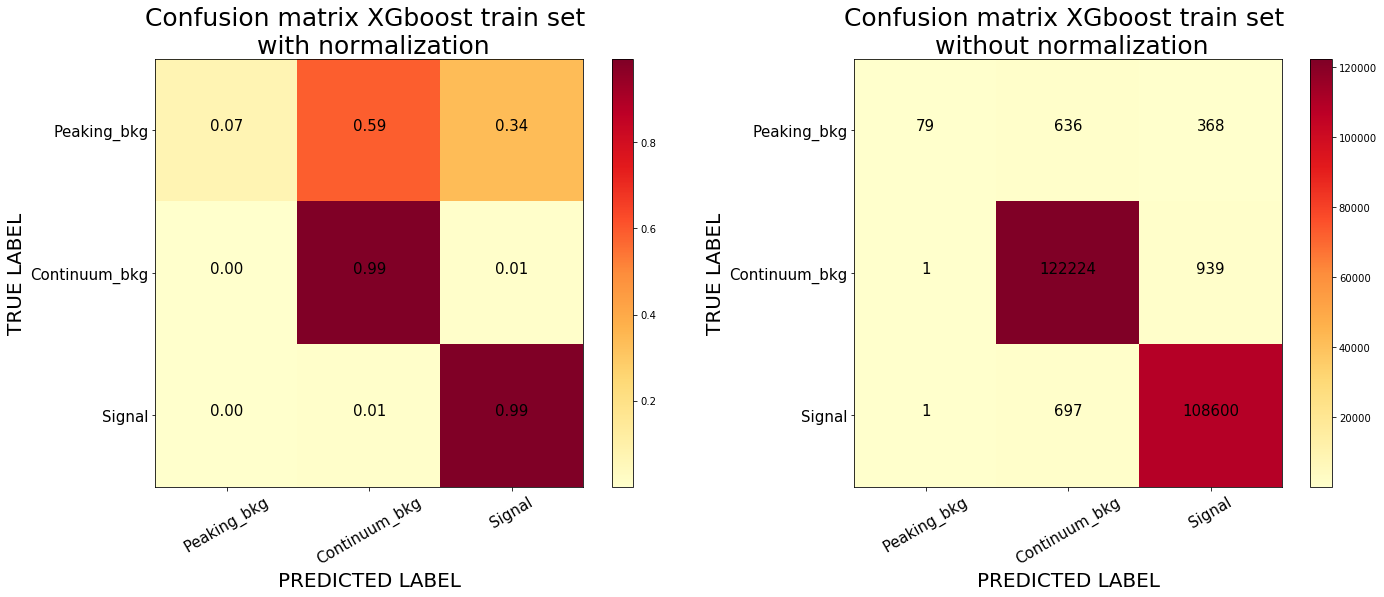

In [96]:
import itertools
plot_confusion_matrix(cnf_matrix_xg_train, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title1="Confusion matrix XGboost train set \n with normalization",
                      title2='Confusion matrix XGboost train set \n without normalization')

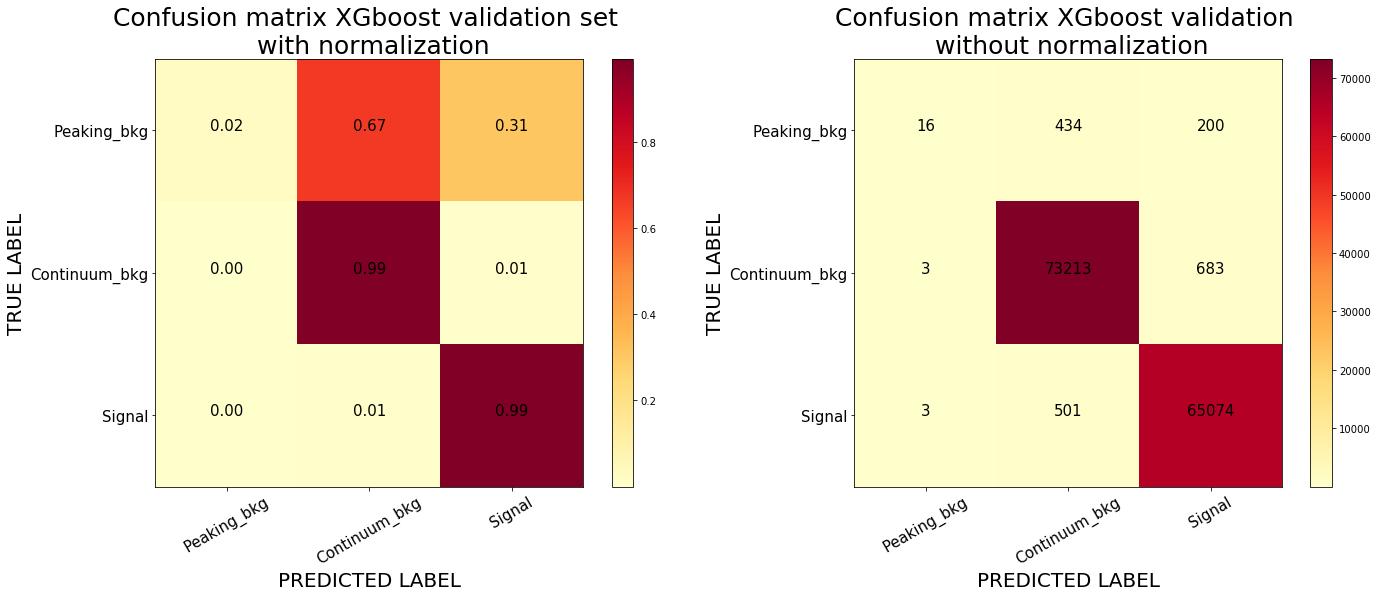

In [97]:
cnf_matrix_xg_val = confusion_matrix(Y_Validation_single_col,y_pred_val)

plot_confusion_matrix(cnf_matrix_xg_val, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title1="Confusion matrix XGboost validation set \n with normalization",
                      title2='Confusion matrix XGboost validation \n without normalization')

In [98]:
joblib.dump(model_xgboost.best_estimator_, "xgboost_model.dat")

['xgboost_model.dat']

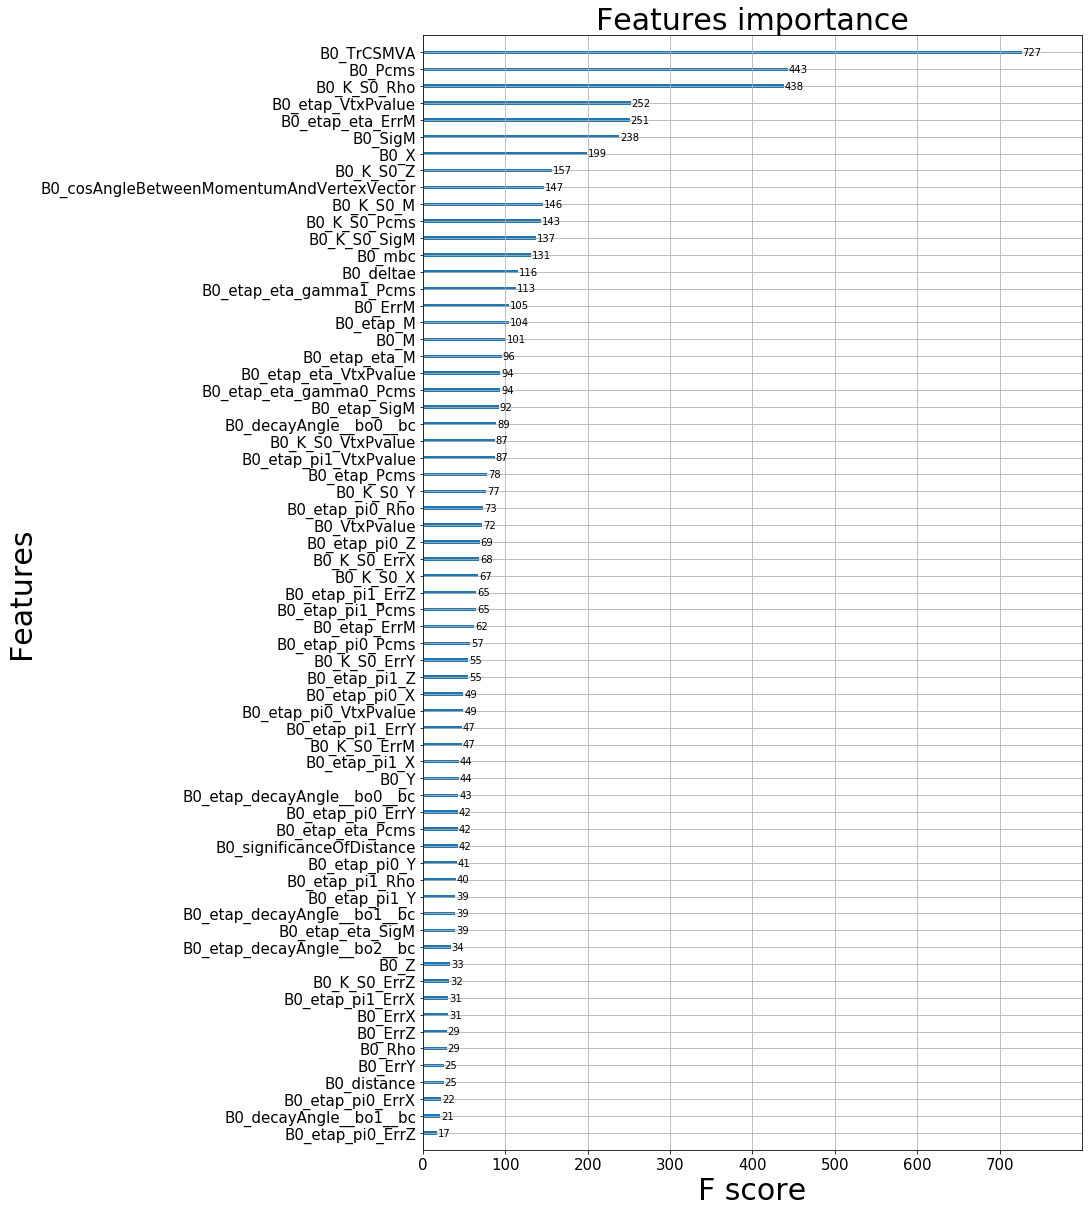

In [99]:
fig=plt.figure()
fig.set_size_inches(30.5, 20.5)
plt.tick_params(labelsize=15)
xgb.plot_importance(model_xgboost.best_estimator_, ax=plt.gca())
plt.title("Features importance",fontsize=30)
plt.ylabel("Features",fontsize=30)
plt.xlabel("F score",fontsize=30)
fig.subplots_adjust(left=0.6)  